##Import Libraries

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

##Define Constants

In [2]:
pi = np.pi

##Define Functions

In [3]:
def RC_pulse(beta,num_taps,sps):
  # This function gives the Raised Cosine pulse
  high = int(num_taps/2) + 1       # Upper Limit of time index
  low = -int(num_taps/2)         # Lower limit of time index
  Ts = sps             # Sampling Time
  t = np.arange(low, high)+0.001
  h = np.sinc(t/Ts) * np.cos(np.pi*beta*t/Ts) / (1 - (2*beta*t/Ts)**2)# The RC pulse
  time = t/sps                    # Time index to actual time (in us)
  return time,h

def SRRC_pulse(beta,num_taps,sps):
  # This function gives the Root Raised Cosine pulse
  # beta:     Bandwidth expansion factor
  # num_taps: number of taps to approximate the pulse
  # sps:      number of samples per symbol
  high = (num_taps+1)/2           # Upper Limit of time index
  low = -((num_taps+1)/2)         # Lower limit of time index
  Ts = sps                        # Sampling Time

  time = np.linspace(low,high,num_taps)
  h=np.zeros(num_taps)
  for i in range(len(time)):
    t = time[i]
    if t==0:
      h[i]=1-beta+4*beta/np.pi
    elif (t==1/(4*beta)):
      h[i] = (beta/2)*((1+2/np.pi)*np.sin(np.pi/(4*beta))+(1-2/np.pi)*np.cos(np.pi/(4*beta)))
    elif (t==-1/(4*beta)):
      h[i] = (beta/2)*((1+2/np.pi)*np.sin(np.pi/(4*beta))+(1-2/np.pi)*np.cos(np.pi/(4*beta)))
    else:
      h[i] = (np.sin(np.pi*(1-beta)*t/Ts)+4*beta*t/Ts*np.cos(np.pi*(1+beta)*t/Ts))/(np.pi*t/Ts*(1-np.power((4*beta*t/Ts),2)))

  return time,h

def upsample(data,upsampling_factor):
  # This function upsamples the input signal "data" by an upsampling factor "upsampling_factor"
  data_size = len(data)
  data_upsampled = np.zeros(upsampling_factor*data_size,)
  for i in range(data_size):
    data_upsampled[i*upsampling_factor] = data[i]
  return data_upsampled

def pulse_shaping(data,h):
  # This function shapes the symbols with Raised Cosine pulse h
  # data_symbols: bits required to be shaped
  # h: srrc pulse

  pulse_shaped_data =[]
  data_shaped = np.convolve(data,h)
  data_shaped = data_shaped/np.max(data_shaped)
  pulse_shaped_data.append(data_shaped)
  pulse_shaped_data = np.array(pulse_shaped_data)

  return pulse_shaped_data

def receive_filter(data,h):
  # This function shapes the waveform with the  Matched receive filter
  data_rx_shaped=[]
  # Shape Data with Matched filter
  data_shaped = np.convolve(data,h)
  data_shaped = data_shaped/np.max(data_shaped)
  data_rx_shaped.append(data_shaped)
  # convert lists to arrays
  data_rx_shaped = np.array(data_rx_shaped)
  return data_rx_shaped

def sampler(data_shaped,data_symbols,offset,sps):
  # This function samples the received signal and returns the samples
  # data_shaped: signal to be sampled
  # data_symbols: data symbols (BPSK in our example)
  # offset: starting point of sampling
  data_size = data_symbols.shape[0]
  sample_list=[]
  pointer = offset
  for loop1 in range(data_size):
    sample = data_shaped[pointer]
    pointer = pointer+sps
    sample_list.append(sample)
  samples = np.array(sample_list)
  samples = samples/np.max(samples)
  return samples

def add_noise(data, snr):
  # This function adds noise of SNR "snr"(in dB) to signal "data" and returns the noisy signal
  data_size = len(data)
  noise = np.random.randn(data_size,)
  snr_lin = np.power(10,snr/10)
  gamma = rayleigh_fading(data)
  data = np.sqrt(data_size)*data/(np.linalg.norm(data))
  noise = noise/np.linalg.norm(noise)
  noise = noise*np.sqrt(data_size)/np.sqrt(2*snr_lin)
  data_noisy = data*gamma + noise

  return data_noisy

def error_rate_calculator(input_data,target_data):
  # This function calculates the symbol error rate between "input data" and "target_data"
  testing_symbols_lin = target_data
  testing_outputs_lin = input_data
  error = 0
  for i in range(len(testing_symbols_lin)):
    if ((testing_symbols_lin[i])!=(testing_outputs_lin[i])):
      error = error + 1
  error_rate = error/len(testing_symbols_lin)
  return error_rate


def rayleigh_fading(data):
# This function introduces Rayleigh distributed randomness to the SNR of the received samples
# We generate the Rayleigh from gaussian distribution
  data_length = len(data)
  alpha_1 = np.random.randn(data_length)/np.sqrt(2)
  alpha_2 = np.random.randn(data_length)/np.sqrt(2)
  gamma = np.sqrt(alpha_1**2+alpha_2**2)

  return gamma

##Design the Raised Cosine Pulses

In [4]:
# Parameters of RC Pulse:
num_taps = 1001             # No of data points used to represent the pulse
beta = 0.3                  # Bandwidth expansion factor
sps = 100                   # No of samples per symbol


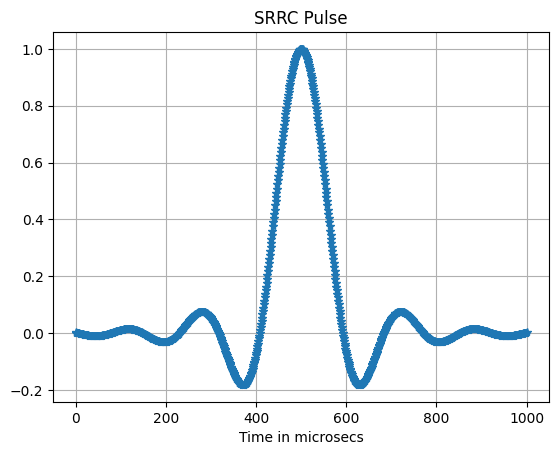

1001


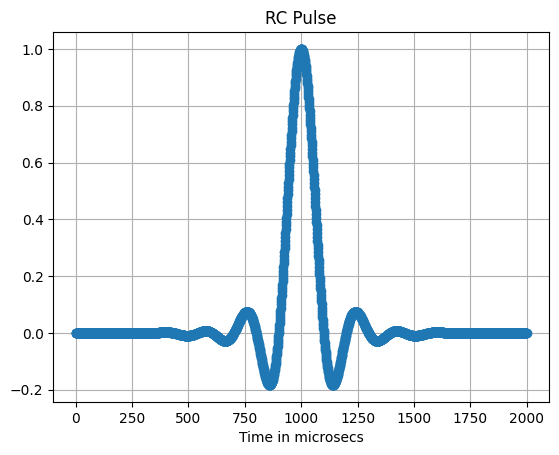

In [5]:
# The following segment of code generates and plots the SRRC pulse according to the above parameters

t,h = SRRC_pulse(beta,num_taps,sps)
h = h/np.max(h)
plt.plot(h,'*-')
plt.grid(True)
plt.xlabel("Time in microsecs")
plt.title("SRRC Pulse")
plt.show()
print(len(h))

# The following segment of code generates and plots the RC pulse according to the above parameters
h_h = np.convolve(h,h)
h_h = h_h/sps
h_h = h_h/np.max(h_h)
plt.plot(h_h,'o-')
plt.grid(True)
plt.xlabel("Time in microsecs")
plt.title("RC Pulse")
plt.show()


##Simulation for BPSK

In [6]:
# Parameters of simulation
data_size = 100000          # No of symbols over which we simulate
# Define the offset
offset = int(len(h_h)/2)    # The offset is necessary to ignore the no-bit response at the beginning and at the end
# Define the SNR range of testing
SNR_dB = np.linspace(0,8,9)

In [7]:
# Create symbols
data_symbols = np.sign(np.random.randn(data_size,))
# Upsample Data
data_upsampled = upsample(data_symbols,100)
# Shape symbols with Tx filter
data_tx_shaped = pulse_shaping(data_upsampled,h)
# Reshape to a linear vector
data_tx_shaped = data_tx_shaped.reshape(-1,)
# Shape symbols with Rx filter
data_rx_shaped = receive_filter(data_tx_shaped,h)
# Reshape to a linear vector
data_rx_shaped = data_rx_shaped.reshape(-1,)
# Sample the Rx Signal
data_samples = sampler(data_rx_shaped,data_symbols,offset,sps)

##Test over Rayleigh Fading Channel

In [8]:
ber_bpsk = np.zeros(len(SNR_dB))    # Placeholder for the BER values

for i in range(len(SNR_dB)):
  snr = SNR_dB[i]
  print(snr)
  # Introduce Rayleigh Fading
  # Add AWGN with fading
  testing_data_samples_noisy = add_noise(data_samples,snr)
  # Demodulate Data
  demodulated_data = np.sign(testing_data_samples_noisy)
  # Note: Since this simulation is for BPSK, the demodulation is trivially a sign bit operation. An extension to QPSK is also very trivial.
  #       However, for larger constellations, the demodulation is more involved and requires a separate function.
  #       The extension is left for the learner to explore.

  # calculate symbol error
  ber_bpsk[i] = error_rate_calculator(demodulated_data,data_symbols)

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0


##Plot the Performance

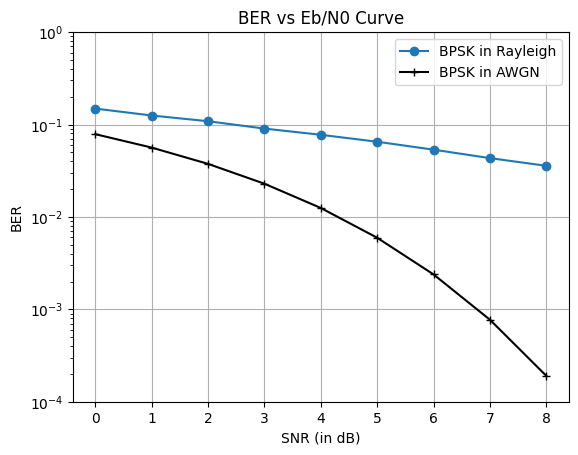

In [9]:
SNR_lin = np.power(10,SNR_dB/10)
bpsk_err=[]
for SNR in SNR_lin:
  bpsk_err.append(math.erfc(np.sqrt(SNR))/2)       # Calculates the Theoretical BER for BPSK in AWGN
# Plot Simulated Values
plt.semilogy(SNR_dB,ber_bpsk,'o-',label='BPSK in Rayleigh')
# Plot Theoretical Values
plt.semilogy(SNR_dB,bpsk_err,'k+-',label='BPSK in AWGN')
plt.legend()
plt.ylim(1e-04,1.0)
plt.grid(True)
plt.xlabel("SNR (in dB)")
plt.ylabel("BER")
plt.title("BER vs Eb/N0 Curve")
plt.savefig("BER curve")
plt.show()